<a href="https://colab.research.google.com/github/carrotjamb/AIMI-Intern-Part-1-Files/blob/main/AIMI_Project_Part_1_Extracting_Labels_from_Radiology_Reports_v11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AIMI High School Internship 2023
### Notebook 1: Extracting Labels from Radiology Reports

**The Problem**: Given a chest X-ray, our goal in this project is to predict the distance from an endotracheal tube to the carina. This is an important clinical task - endotracheal tubes that are positioned too far (>5cm) above the carina will not work effectively.

In order to train a model that can predict tube distances given chest X-rays, we require a ***training set*** with chest X-rays and labeled tube distances. However, when working with real-world medical data, important labels (e.g. endotracheal tube distances) are often not annotated ahead of time. The only data that a researcher has access to are the raw images and free-form clinical text written by the radiologist.

**Your First Task**: Given a set of chest X-rays and paired radiology reports, your goal is to use natural language processing tools to extract endotracheal tube distances from the reports.

**Looking Ahead**: When you complete this task, you should have a training dataset with chest X-rays labeled with endotracheal tube distances. You will later use this dataset to train a computer vision model that predicts the tube distance given an image.

### Load Data

Upload the four sets of files: `mimic-train.zip`, `mimic-test.zip`, `mimic_train_student.csv`, and `mimic_test_student.csv`. It should take about 10 minutes for these files to be uploaded. Then, run the following cells to unzip the dataset (which should take < 10 seconds)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/drive-download-20230620T044532Z-001\ \(1\).zip

Archive:  /content/drive/MyDrive/Colab Notebooks/drive-download-20230620T044532Z-001 (1).zip
  inflating: mimic_test_student.csv  
  inflating: mimic_train_student.csv  
  inflating: mimic-test.zip          
  inflating: mimic-train.zip         


In [ ]:
!unzip /content/mimic-train.zip

Streaming output truncated to the last 5000 lines.
  inflating: mimic-train/17106/54055/90984.jpg  
   creating: mimic-train/14738/
  inflating: mimic-train/14738/60451.txt  
  inflating: mimic-train/14738/53072.txt  
  inflating: mimic-train/14738/56287.txt  
   creating: mimic-train/14738/60451/
  inflating: mimic-train/14738/60451/88752.jpg  
  inflating: mimic-train/14738/60579.txt  
   creating: mimic-train/14738/53072/
  inflating: mimic-train/14738/53072/82735.jpg  
   creating: mimic-train/14738/56287/
  inflating: mimic-train/14738/56287/88167.jpg  
   creating: mimic-train/14738/60579/
  inflating: mimic-train/14738/60579/89365.jpg  
   creating: mimic-train/13042/
  inflating: mimic-train/13042/58438.txt  
   creating: mimic-train/13042/58438/
  inflating: mimic-train/13042/58438/94003.jpg  
   creating: mimic-train/13685/
  inflating: mimic-train/13685/60316.txt  
   creating: mimic-train/13685/60316/
  inflating: mimic-train/13685/60316/88058.jpg  
  inflating: mimic-train

### Understanding the Data

Let's first go through some terminology. Medical data is often stored in a hierarchy consisting of three levels: patient, study, and images.
- Patient: A patient is a single unique individual.
- Study: Each patient may have multiple sets of images taken, perhaps on different days. Each set of images is referred to as a *study*.
- Images: Each study consists of one or more *images*.

Chest X-ray images and radiology reports are stored in `data/` and are organized as follows:
- `data/mimic-train`:
  - Images: The MIMIC training set consists of 5313 subfolders, each representing a patient. Every patient has one or more studies, which are stored as subfolders. Images are stored in study folders as `.jpg` files with 512x512 pixels.
  - Text: Reports are stored in patient folders with  `.txt` extensions. The filename corresponds to the study id and the content of the report applies to all images in the corresponding study.
- `data/mimic-test`: The MIMIC test set is organized in a similar fashion as the MIMIC training set. Note that this is a held-out test set with 500 images that we will use for scoring models, so reports are not provided!
- `data/mimic_train_student.csv`: This spreadsheet provides mappings between image paths, report paths, patient ids, study ids, and image ids for samples in the training set.
- `data/mimic_test_student.csv`: This spreadsheet provides mappings between image paths, patient ids, study ids, and image ids for samples in the test set.

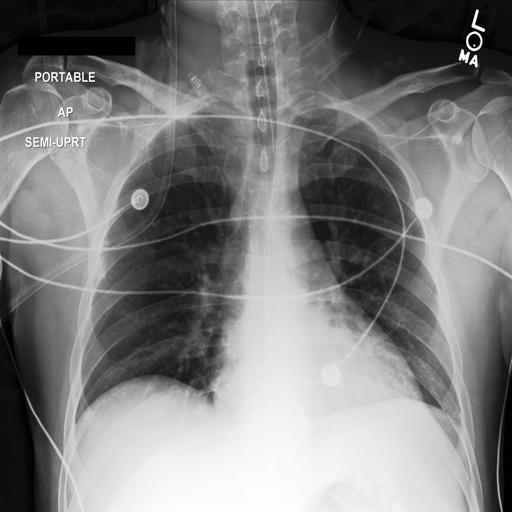

In [ ]:
# Example Image
from PIL import Image
img = Image.open(f"/content/mimic-train/12000/59707/90529.jpg")
img.show()

In [ ]:
# Example Text Report
with open(f"/content/mimic-train/12008/57336.txt", "r") as f:
  txt = f.readlines()
txt

['                                 FINAL REPORT\n',
 ' EXAMINATION:  Chest radiograph.\n',
 ' \n',
 ' INDICATION:  ___-year-old female with endotracheal tube placement. Assess\n',
 ' placement.\n',
 ' \n',
 ' TECHNIQUE:  Single portable frontal chest radiograph.\n',
 ' \n',
 ' COMPARISON:  None.\n',
 ' \n',
 ' FINDINGS: \n',
 ' \n',
 ' Enteric feeding tube coursing mid line with tip within the stomach and side\n',
 ' ports below the level of the diaphragm. An endotracheal tube is seen 6 cm\n',
 ' above the level of the carina at the inferior level of the clavicles. A left\n',
 ' subclavian port tip is seen within the mid SVC.\n',
 ' \n',
 ' The lungs are well inflated. No pleural effusion. No pneumothorax. 2.8 x 0.9\n',
 ' cm ovoid opacity projecting over the right mid lung is noted. An additional\n',
 ' 1.7 x 1.0 cm opacity projecting over the right lower lobe is most consistent\n',
 ' with a pulmonary vessel on end. Elevation of the left hemidiaphragm is noted\n',
 ' with associated 

In [ ]:
import pandas as pd
# Load csv file with mappings
pd.read_csv('/content/drive/Shareddrives/2023 AIMI Summer Internship RESOURCES/Dataset/MIMIC III _ Chest/mimic_train_student.csv')

FileNotFoundError: ignored

### Extracting Tube Distance Labels

You're now ready to begin this task! Keep in mind that not every chest X-ray provided in the training set contains endotracheal tube distance information, and there may be several edge cases to consider.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 104.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.6 MB/s eta 0:00:00


In [ ]:
#Model Used: https://huggingface.co/d4data/biomedical-ner-all
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch
import re

#Set up GPU and model
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = AutoModelForTokenClassification.from_pretrained("d4data/biomedical-ner-all")
model.to(device)

tokenizer = AutoTokenizer.from_pretrained("d4data/biomedical-ner-all")

pipe = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple", device=0) # pass device=0 if using gpu

#Carina Measurement Finder
def find_carina_measurement (directory):
  #Trying to find carina measurments from radiology report
  answer = ''
  is_millimeters = False

  #Open Text File/Radiology Report
  with open(directory, "r") as f:
    radiology_report = f.readlines()

  #Convert Report (list) to String to Pass through Model
  radiology_report_str = ''

  for r in radiology_report:
    radiology_report_str = radiology_report_str + r

  #Use Model to Label Text in Report
  categorized_text = pipe(radiology_report_str)

  #Identify Labelled Text that are Measured Distances
  measured_distances = []
  for i in categorized_text:
    if i['entity_group'] == 'Distance':
      # print(i['word'])

      distance = i['word']
      distance = i['word'].replace('. ', '.')
      measured_distances.append(distance)

  #Case 1: No measurements found
  if len(measured_distances) == 0:
    answer = None

  #Case 2: One measurement found
  elif len(measured_distances) == 1:
    answer = measured_distances[0]

  #Case 3: Two of the same measurements found
  elif measured_distances[0] == measured_distances[1]:
    answer = measured_distances[0]

  #Case 4: Two different measurements found
  else:
    print(measured_distances)
    answer = closest_measurement_to_word(radiology_report_str, measured_distances)

  answer = removeUnits(answer)
  answer = removeCharacters(answer)
  answer = toFloat(answer)

  #Divide Answer by 10 if in mm to convert to cm
  if measurement>13.0:
    answer = answer/10.0

  return answer

#Finds measurement closest to the word "tube" or "cadina" in the case there are multiple measurements in a report
def closest_measurement_to_word (radiology_report_str, measured_distances):
    #List of indexes
    tube_appearances = []
    closest_measurement_to_tube_string = ''
    closest_measurement_to_tube = len(radiology_report_str)

    #Loop through each measurement found
    for measurement in measured_distances:

      #Find index of measurement in radiology report
      if radiology_report_str.count(measurement)==1:
        measurement_index = radiology_report_str.index(measurement)
      else:
        occurences_unit = [i for i in range(len(radiology_report_str)) if radiology_report_str.startswith("cm", i)]
        occurences_measurement = [i for i in range(len(radiology_report_str)) if radiology_report_str.startswith(measurement, i)]

        closest_measurement_to_units = len(radiology_report_str)
        closest_measurement_to_units_index = 0

        for m in occurences_measurement:
          for u in occurences_unit:
            if abs(m - u) <= closest_measurement_to_units:
              closest_measurement_to_units = abs(m - u)
              closest_measurement_to_units_index = m

        measurement_index = closest_measurement_to_units_index

      test_str = radiology_report_str
      test_sub = ''

      if 'carina' in radiology_report_str:
      # if findWholeWord('seek')('those who seek shall find'):
        #return list of occurences of the word "tube" in radiology report
        test_sub = "carina"

      elif 'tube' in radiology_report_str:
        test_sub = "tube"

      occurences = [i for i in range(len(test_str)) if test_str.startswith(test_sub, i)]

      for o in occurences:
          if abs(o - measurement_index) <= closest_measurement_to_tube:
            closest_measurement_to_tube = abs(o - measurement_index)
            closest_measurement_to_tube_string = measurement


      if len(closest_measurement_to_tube_string) == 1:
        for measurement in measured_distances:
          if closest_measurement_to_tube_string in measurement and ('mm' in measurement or 'cm' in measurement):
            closest_measurement_to_tube_string = measurement
        # temp_measurement_index = measurement_index+1
        # while closest_measurement_to_tube_string.endswith('m') == False:
        #   closest_measurement_to_tube_string =  closest_measurement_to_tube_string + radiology_report_str[temp_measurement_index]
        #   temp_measurement_index += 1

      # if len(closest_measurement_to_tube_string) == 1 :

    return closest_measurement_to_tube_string

def removeUnits(answer):
  #Remove Units from Answer
  if "cm" in answer:
    answer = answer.replace('cm', '')
  elif "mm" in answer:
    answer = answer.replace('mm', '')
    return answer

def removeCharacters(answer):

  #Replace -, or, to, and, point, and or from answer
  if "-" in answer:
    starting = answer.index('-')
    answer = answer[starting+1:]

  elif "to" in answer:
    starting = answer.index('to')
    answer = answer[starting+1:]

  elif "and" in answer:
    starting = answer.index('and')
    answer = answer[starting+1:]

  elif "point" in answer:
    starting = answer.index('point')
    answer = answer.replace('point', '.')

  elif "or" in answer:
    starting = answer.index('point')
    answer = answer[starting+1:]


  #Remove All Other Extraneous Letters from String
  final_measurement = answer
  numbers = ['0','1','2','3','4','5','6','7','8','9','.']
  for m in answer:
    if m not in numbers:
      final_measurement = final_measurement.replace(m, '')

  return final_measurement

def toFloat(answer):
    return float(answer)


# def findWholeWord(w):
#     return re.compile(r'\b({0})\b'.format(w), flags=re.IGNORECASE).search

In [ ]:
# import required module
import os
import csv
import torch
# assign directory
directory = '/content/mimic-train'

list_files = []
with open('/content/mimic_train_student.csv', 'r') as csvfile:
    datareader = csv.reader(csvfile)
    for row in datareader:
        list_files.append(row[5])

with open('/content/drive/MyDrive/Colab Notebooks/CSVs_from_part_1 /results_1.17.csv', 'w', encoding='UTF8', newline='') as f:
  writer = csv.writer(f)
  writer.writerow(['report', 'measurement'])
  # iterate over files in
  # that directory
  for filename in list_files:
      f = filename
      # checking if it is a file
      if os.path.isfile(f) and f.endswith(".txt"):
        measurement = ''
        is_millimeters = False
        final_measurement = ''
        float_final_measurement = 0.0

        try:
          measurement = find_carina_measurement(f)

          if measurement == None:
            raise TypeError(None)

          # #Remove Units from String
          # if "cm" in measurement:
          #   measurement = measurement.replace('cm', '')
          # elif "mm" in measurement:
          #   measurement = measurement.replace('mm', '')
          #   is_millimeters = True

          # #Remove - or to from measurement
          # if "-" in measurement:
          #   starting = measurement.index('-')
          #   measurement = measurement[starting+1:]

          # elif "to" in measurement:
          #   starting = measurement.index('to')
          #   measurement = measurement[starting+1:]

          # elif "and" in measurement:
          #   starting = measurement.index('and')
          #   measurement = measurement[starting+1:]

          # elif "point" in measurement:
          #   starting = measurement.index('point')
          #   measurement = measurement.replace('point', '.')

          # elif "or" in measurement:
          #   starting = measurement.index('point')
          #   measurement = measurement.replace('point', '.')


          # #Remove Extraneous Letters from String
          # final_measurement = measurement
          # numbers = ['0','1','2','3','4','5','6','7','8','9','.']
          # for m in measurement:
          #   if m not in numbers:
          #     final_measurement = final_measurement.replace(m, '')

          # #Convert Final Measurement to Float
          # float_final_measurement = float(final_measurement)

          # #Divide Final Measurement Float by 10 if in mm (to get to cm)
          # if is_millimeters:
          #   float_final_measurement = float_final_measurement/10.0
        except ValueError:
          measurement = None
          # write the data
        except TypeError:
          measurement = None


        writer.writerow([f, measurement])

['less than 6 cm', 'advanced', '2 cm']
['3.8 cm', '2.8 cm']
['2', '2 cm', '2.2', '1 cm']
['4 cm', '2.6 mm']
['2.9 cm', '5.3 cm', '2.9 cm', '5.3 cm']
['1.5 cm', '2 cm']
['3 cm', '2.4 cm', '3 cm']
['3', '6 cm']
['3 - 4 cm', '7 cm', '3 - 4 cm']
['less than a cm', '2 or 3 cm']
['less than 2 cm', '15 mm']
['3', '7 cm']
['no less than 7 cm', '3 cm']
['less than 8 cm', '3 cm']
['1 - 2 cm', 'centimeters']
['2.4 cm', '1 - 2 cm']
['2.7 cm', '7 cm']
['2', 'less than 2 cm', '1 cm']
['2', 'less than 2 cm', '1 cm']
['more than 2 cm', '1 cm']
['2', '3 cm', '2', '5 cm', '3 cm', '.5 cm']
['4.5 cm', '4', '5 cm', '4', '6 cm', '4.6 cm']
['no less than 8 cm', 'more than 3 cm']
['2.8 cm', 'several centimeters', '2.8 cm']
['7 cm', '7cm']
['no less than 6 cm', '2 - 3 cm']
['5 cm', '5']
['7 cm', '1 cm below', '1 cm']
['7 cm', '1 cm below', '1 cm']
['3.4 cm', '5 cm']
['than 16 mm', 'a centimeter']
['1.7 cm', '7 cm']
['3 cm', '1', '3 cm']
['3 cm', '1 cm', '1 cm', '5.1 cm']
['2.7 cm', '2', '7']
['3.5 cm', '3 cm',

# Test Code

In [ ]:
directory = 'mimic-train/12882/53642.txt'
with open(directory, "r") as f:
  radiology_report = f.readlines()

radiology_report


['                                 FINAL REPORT\n',
 ' INDICATION:  Left subdural hematoma and probable hemothorax.  Evaluate for\n',
 ' interval change.\n',
 ' \n',
 ' COMPARISON:  Chest radiograph from ___.  CT of the torso from ___.\n',
 ' \n',
 ' TECHNIQUE:  A single semi-upright AP view of the chest was obtained.\n',
 ' \n',
 ' FINDINGS:  Again, the endotracheal tube is low, approximately 1.3 cm from the\n',
 ' carina. An enteric tube is present with the tip in the stomach.  A left\n',
 ' subclavian central venous catheter is present with the tip in the low SVC.\n',
 ' \n',
 ' The lung volumes are low, limiting evaluation.  A retrocardiac opacity is\n',
 ' likely due to atelectasis.  There is no new focal airspace opacity or\n',
 ' pulmonary edema.  There is no pneumothorax.  There may be a small left pleural\n',
 ' effusion, which is unchanged.  There is no right pleural effusion.  The\n',
 ' cardiomediastinal silhouette is unchanged.\n',
 ' \n',
 ' IMPRESSION:\n',
 ' 1.  Unchang